In [65]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 19px;
font-family: Georgia, serif;
</style>

# Content
* [The Problem](#problem)
* [The Libraries](#libraries)
* [The Data](#data)
    * [Exploratinon](#data_1)
        * [Structure](#data_1_1)
        * [Summary](#data_1_2)
    * [Prepration](#data_2)
        * [Trip duration](#data_2_1)
        * [Latitude and Longitude ](#data_2_2)
        * [Datetime format](#data_2_3)
    * [Visualization](#data_3)
        * [Intial analysis ](#data_3_1)
        * [distance and direction](#data_3_2)
        * [Data transform](#data_3_3)

# The Problem <a class="anchor" id="problem"></a>

If you are going to meeting you need to be on time and thats the idea of the model is to predict the time you will need to move from point a to point b 

# Installing,Importing required libraries <a class="anchor" id="libraries"></a>

In [66]:
%matplotlib inline 
# the use of `%matplotlib inline`, allowing the display of graphs inline in iPython Notebook.
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

# Loading the Data <a class="anchor" id="data"></a>
## 1.1 Load the data using the Pandas `read_csv` function

In [67]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

## 1.2 Data Exploration <a class='anchor' id='data_1'></a>

### 1.2.1 File structure <a class='anchor' id='data_1_1'></a>
Let's start off by exploring the files we just imported, using Pandas `describe` function

In [68]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.986,40.736,-73.980,40.760,N,1040
1,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978,40.764,-73.992,40.750,N,827
2,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989,40.744,-73.973,40.749,N,614
3,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990,40.731,-73.991,40.749,N,867
4,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789,40.647,-73.987,40.759,N,4967
...,...,...,...,...,...,...,...,...,...,...,...
999995,id2875371,2,2016-03-25 15:48:58,2016-03-25 15:53:12,1,-73.959,40.772,-73.954,40.786,N,254
999996,id1038420,2,2016-05-04 19:36:44,2016-05-04 19:43:58,1,-73.971,40.764,-73.956,40.778,N,434
999997,id3238884,2,2016-05-19 08:50:41,2016-05-19 09:12:27,2,-73.982,40.771,-73.971,40.759,N,1306
999998,id3652642,2,2016-04-04 14:37:59,2016-04-04 15:16:36,6,-73.983,40.766,-74.006,40.712,N,2317


### 1.2.2 Data Summary <a class='anchor' id='data_1_2'></a>

In [69]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,954.885
std,0.499,1.316,0.065,0.034,0.065,0.036,3882.070
min,1.000,0.000,-121.933,34.360,-121.933,34.360,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1074.000
max,2.000,7.000,-61.336,51.881,-61.336,43.921,2227612.000


if we look to the trip duration we will found that the min is 1 second and max is 2227612 == 618.7 hours and thats not logically

# 2. Data prepration <a class='anchor' id='data_2'></a>

We can from the `datetime` extract a lot of informations and see the insights of it, the traffic will diffrence from normal day and week end or seasons, and the seasons of the year is a big point if its winter and the ice fall the traffic will be very slow.

Another big factor is the `passenger_count` the more it's increase ,the trip will be longer from physical view beacuse the vehicle will be heavy and maybe the passengers have diffrent drop points.

Also with `vendor` and `store_and_fwd_flag`. It is possible that looking into it, we find that there's a difference between vendor 1 and vendor 2, and that either one of the two might be corrupting the "shortest route information" because the vendor's employees are less efficient in finding the best routes through New York. This, however, I also find highly unlikely, but it is an alternative to explore (at least look into it and rule it out difinitively). As for `store_and_fwd_flag` -  there is a strong correlation between slow trip times and server disconnects, it could be used as another feature in the training model to predict what time a particular route could take.

And the most important one is the `_lattitude` and `_longitute` variables, can be used for find the distance and directions between coordinates.

## 2.1 Trip outliers clean <a class='anchor' id='data_2_1'></a>

As we find that there is an outliers that the min is 1 second and the max is 618 hours,
so we need to clean that by using standard deviation from the mean.

In [70]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [71]:
train.sort_values(by=['trip_duration'],ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
890796,id3928085,1,2016-05-15 10:16:55,2016-05-15 12:40:03,2,-73.777,40.645,-73.865,40.770,N,8588
257772,id2291596,2,2016-06-15 16:33:21,2016-06-15 18:55:44,1,-73.789,40.643,-73.790,40.647,N,8543
83571,id3360908,1,2016-04-12 09:27:03,2016-04-12 11:49:25,1,-73.951,40.775,-73.960,40.760,N,8542
909132,id1121160,2,2016-05-18 13:42:12,2016-05-18 16:04:14,1,-74.004,40.742,-73.871,40.774,N,8522
672121,id1495760,1,2016-02-29 16:47:15,2016-02-29 19:08:51,1,-73.973,40.744,-73.972,40.743,N,8496
...,...,...,...,...,...,...,...,...,...,...,...
567376,id3686648,1,2016-01-29 11:18:55,2016-01-29 11:18:56,1,-73.972,40.750,-73.972,40.750,N,1
309506,id1520236,1,2016-05-17 09:03:38,2016-05-17 09:03:39,1,-73.820,40.741,-73.820,40.741,N,1
117872,id2959956,1,2016-02-25 04:26:50,2016-02-25 04:26:51,1,-73.806,40.660,-73.806,40.660,N,1
535096,id2517984,1,2016-01-09 00:28:55,2016-01-09 00:28:56,1,-73.862,40.769,-73.862,40.769,N,1


## 2.2 Latitude and Longitude Clean-up <a class='anchor' id='data_2_2'></a>

By searching google we will find that the coordinates of New York is: 

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

Comparing this to our `train.describe()` output we see that there are some coordinate points that outside New York, So we needs to clean that from the data.

In [72]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

## 2.3 Datetime format <a class='anchor' id ='data_2_3'></a>

We just will change the format to be datetime rather than string to be applicable to work with it

In [73]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
val['pickup_datetime'] = pd.to_datetime(val.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
val.loc[:, 'pickup_date'] = val['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) 
val['dropoff_datetime'] = pd.to_datetime(val.dropoff_datetime) 

# 3. Data Visualisation and Analysis <a class='anchor' id='data_3'></a>
The next step is to visualise the data, it's easier to extract relation from graph than a table.
## 3.1 Initial Analysis <a class='anchor' id='data_3_1'></a>
we will plot a histogram of `trip_duration`, splitting the data to 200 bins.

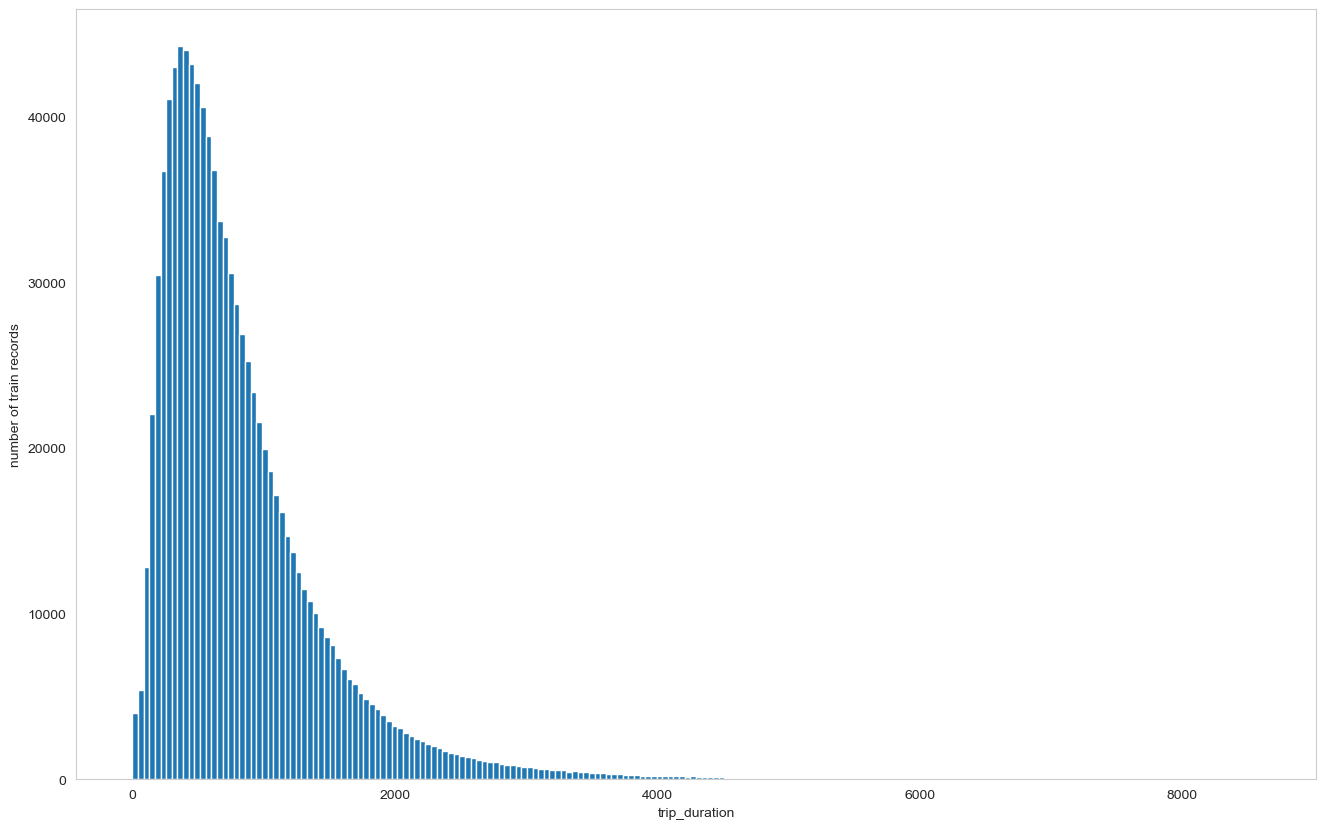

In [74]:
plt.hist(train['trip_duration'].values, bins=200)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.grid()
plt.show()

we will apply a log transformation to the `trip_duration`, since we are doing this to accommodate the leaderboard's scoring metric.

<Axes: xlabel='log_trip_duration', ylabel='Count'>

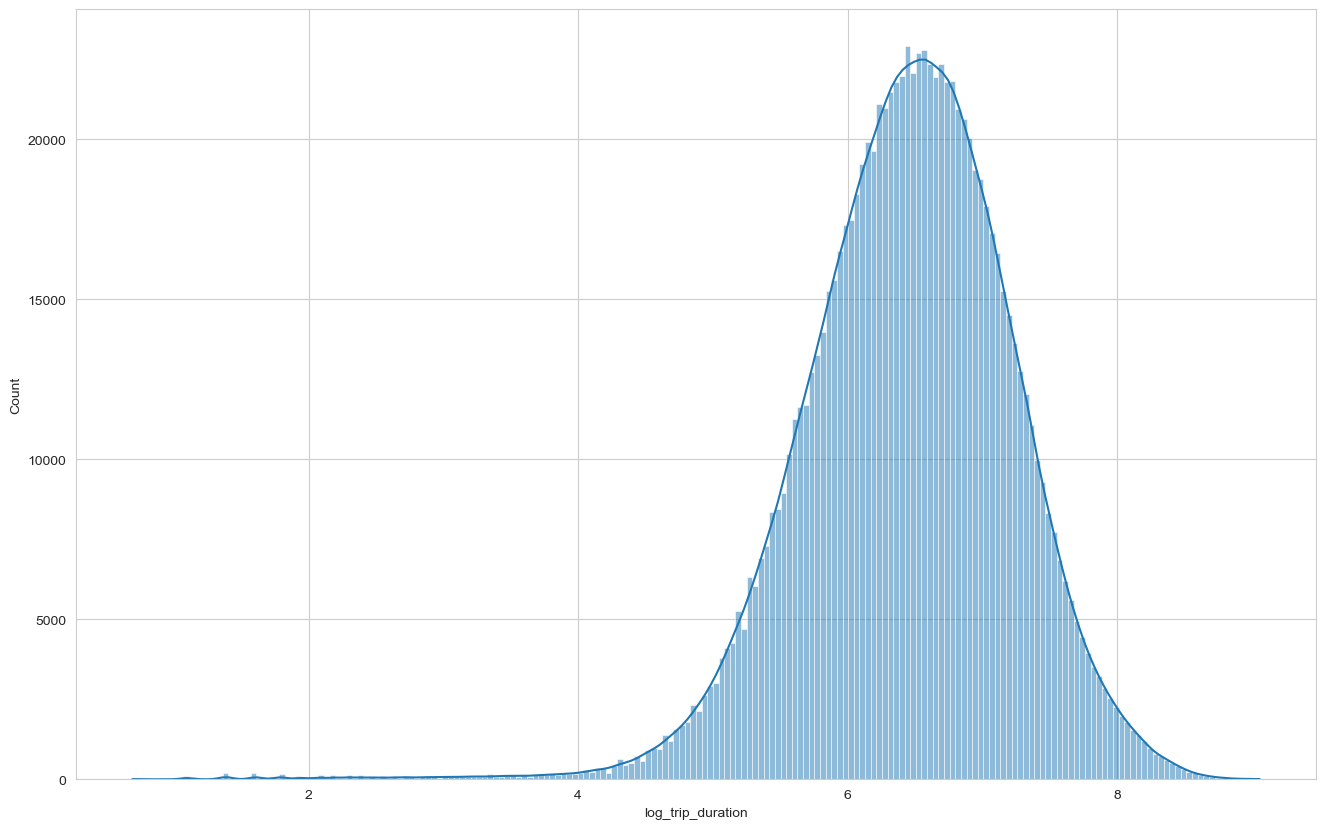

In [75]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
val['log_trip_duration'] = np.log(val['trip_duration'].values + 1)

sns.set_style("whitegrid")
sns.histplot(train["log_trip_duration"], bins =200,kde=True)

Another intersted one is to view the trips over time since this could reveal apparent seasonality in the data and certain trends,

So we will do a timeseries plot for the train and val datasets to see the possible trends and to check if the pattern of both is the same 

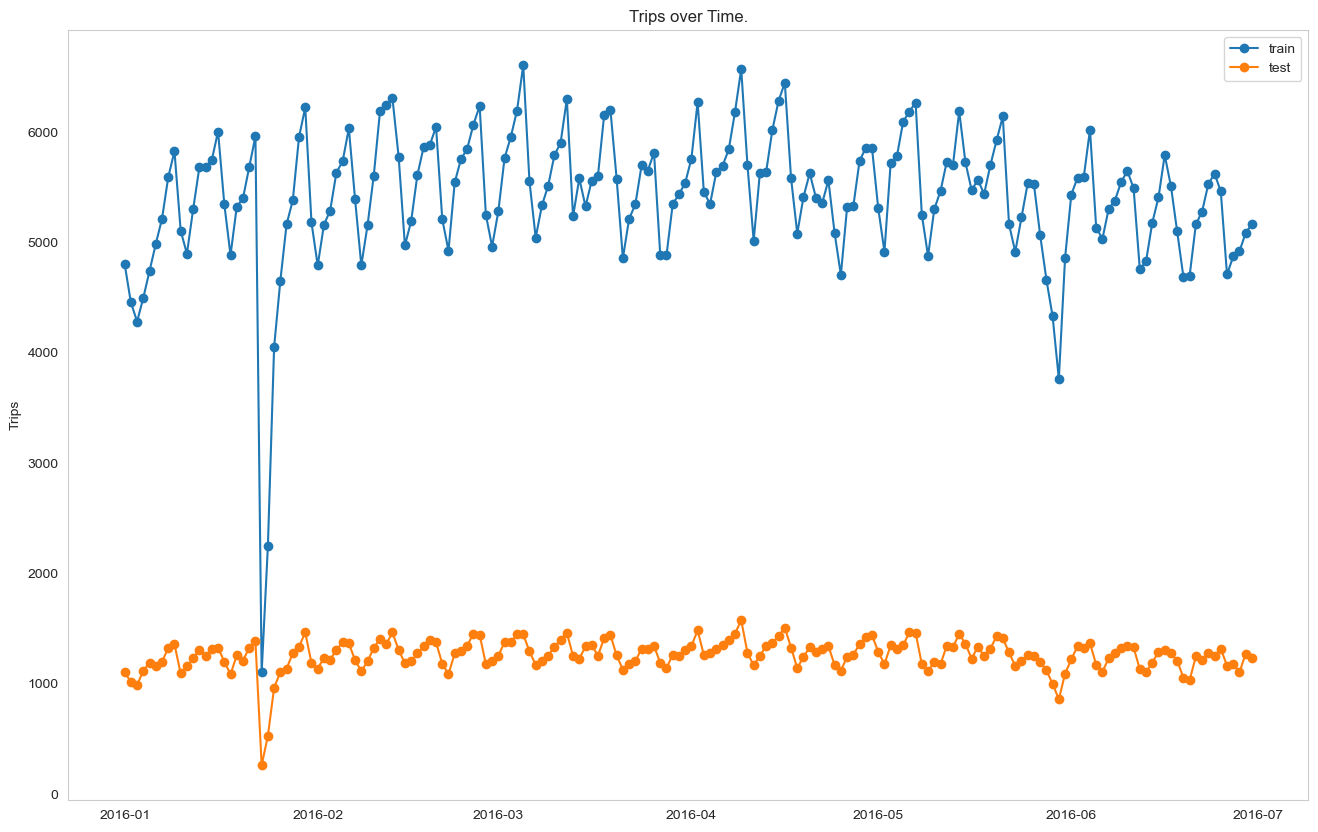

In [76]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(val.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.grid()
plt.show()

It's clear that the two datasets is the same pattern but the val is more narrow beacuse it's smaller,
we can notice that there is a drop of the trips in the end of January, and there is another drop but smaller in late of May.
The first drop because of the winter season, 
The temps are between 18–23 °F (−7 to −5 °C).  (the same temp of our freezer)

Now let's the different between the two vendors

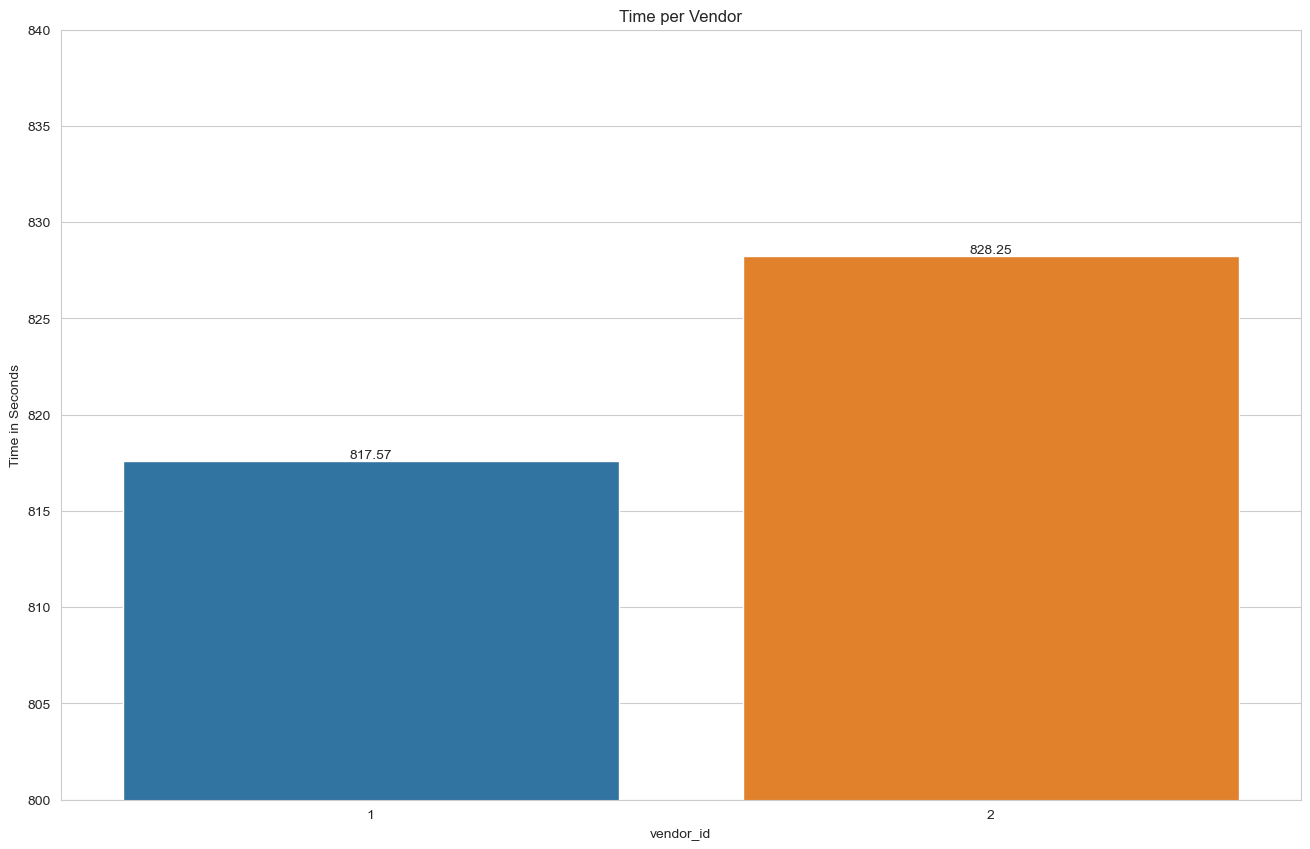

In [77]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.ylim(ymin=800)
plt.ylim(ymax=840)
plt.title('Time per Vendor')
plt.ylabel('Time in Seconds')

ax = sns.barplot(x=plot_vendor.index, y=plot_vendor.values)

for index, value in enumerate(plot_vendor.values):
    ax.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.show()


The graph showing that the difference between the two vendors is nearly 10 seconds and that's not too much

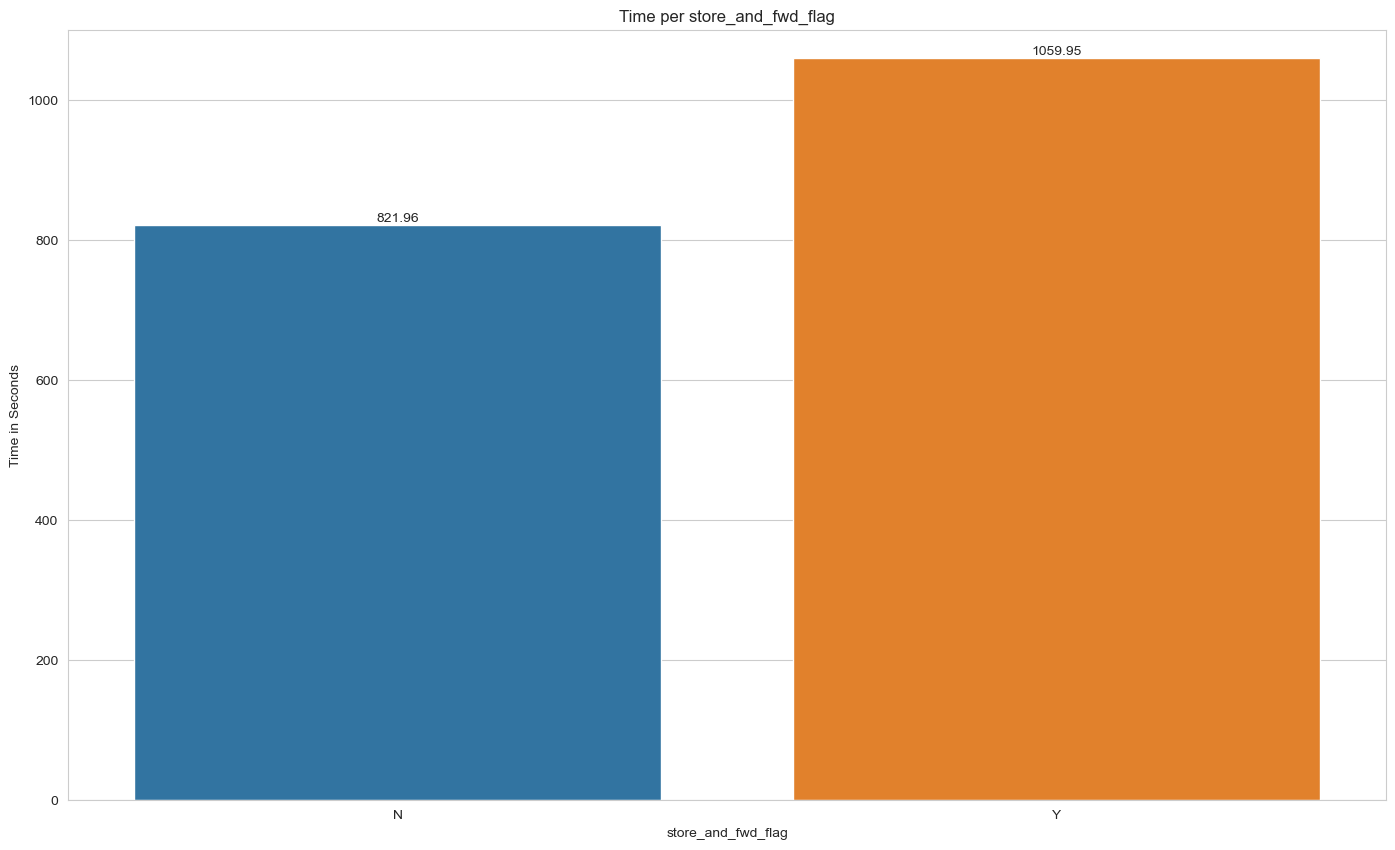

In [78]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1, 1, figsize=(17, 10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.ylabel('Time in Seconds')

# Plot the bar plot using Seaborn and get the axis object (ax)
ax = sns.barplot(x=snwflag.index, y=snwflag.values)

# Annotate each bar with the number of occurrences
for index, value in enumerate(snwflag.values):
    ax.text(index, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()


Here the difference is big, maybe this because one of the vendors didn't record accurately

## 3.2 Distance and Direction <a class='anchor' id='data_3_2'></a>

In [79]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

The function `haversine_array` calculates the Haversine distance between two sets of latitude and longitude coordinates. The Haversine formula is used to compute the distance between two points on a sphere (such as the Earth) given their latitude and longitude.

The function `dummy_manhattan_distance` calculates the "dummy" Manhattan distance between two sets of latitude and longitude coordinates. This distance is not the actual Manhattan distance, but a simplified version that approximates the Manhattan distance using the Haversine formula.

The `bearing_array` function will compute the dirrection between the two points and return the result in degrees.

In [80]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
val.loc[:, 'distance_haversine'] = haversine_array(val['pickup_latitude'].values, val['pickup_longitude'].values, val['dropoff_latitude'].values, val['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
val.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(val['pickup_latitude'].values, val['pickup_longitude'].values, val['dropoff_latitude'].values, val['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
val.loc[:, 'direction'] = bearing_array(val['pickup_latitude'].values, val['pickup_longitude'].values, val['dropoff_latitude'].values, val['dropoff_longitude'].values)

now we inserted the new colomns to the datasets

## 3.3 Data transform <a class='anchor' id='data_3_3'></a>
now we will extract the data from the datetime colomns the on hot encode it to make it easier for the model to understand it

In [81]:
train['month']=train['pickup_datetime'].dt.month
val['month']=val['pickup_datetime'].dt.month

train['DayofMonth']=train['pickup_datetime'].dt.day
val['DayofMonth']=val['pickup_datetime'].dt.day

train['Hour']=train['pickup_datetime'].dt.hour
val['Hour']=val['pickup_datetime'].dt.hour

train['dayofweek']=train['pickup_datetime'].dt.dayofweek
val['dayofweek']=val['pickup_datetime'].dt.dayofweek

In [82]:
len(train.groupby("month").size()),len(val.groupby('month').size())

(6, 6)

The two datasets have 6 months so we can encode it without any problem

In [83]:
len(train.groupby('DayofMonth').size()),len(val.groupby('DayofMonth').size())

(31, 31)

The two datasets have 31 days

In [84]:
len(train.groupby('Hour').size()),len(val.groupby('Hour').size())

(24, 24)

The two datasets have 24 hours

In [85]:
len(train.groupby('dayofweek').size()),len(val.groupby('dayofweek').size())

(7, 7)

The two datasets have 7 days

## 3.4 Creating Dummy Variables <a class='anchor' id='data_3_4'></a>
So for this step we get to the one hot encoding we spoke of earlier.

In [86]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_val = pd.get_dummies(val['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_val = pd.get_dummies(val['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_val = pd.get_dummies(val['store_and_fwd_flag'], prefix='sf', prefix_sep='_')


month_train = pd.get_dummies(train['month'], prefix='m', prefix_sep='_')
month_val = pd.get_dummies(val['month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_val = pd.get_dummies(val['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_val = pd.get_dummies(val['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_val = pd.get_dummies(val['dayofweek'], prefix='dow', prefix_sep='_')

check the output though 

In [87]:
vendor_train.shape,vendor_val.shape

((985141, 2), (229319, 2))

In [88]:
passenger_count_train.shape, passenger_count_val.shape

((985141, 7), (229319, 9))

looks like that the `passenger_count` difference between the train and the val, so we need to clean that

In [89]:
passenger_count_val = passenger_count_val.drop('pc_7', axis = 1)
passenger_count_val = passenger_count_val.drop('pc_8', axis = 1)

passenger_count_val

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
229314,0,1,0,0,0,0,0
229315,0,0,1,0,0,0,0
229316,0,1,0,0,0,0,0
229317,0,1,0,0,0,0,0


In [90]:
passenger_count_train.shape, passenger_count_val.shape

((985141, 7), (229319, 7))

In [91]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_val.shape

((985141, 2), (229319, 2))

In [92]:
month_train.shape,month_val.shape

((985141, 6), (229319, 6))

In [93]:
dom_train.shape,dom_val.shape

((985141, 31), (229319, 31))

In [94]:
hour_train.shape,hour_val.shape

((985141, 24), (229319, 24))

In [95]:
dow_train.shape,dow_val.shape

((985141, 7), (229319, 7))

The last step is to drop the columns that we encoded it.

In [96]:
train.head

<bound method NDFrame.head of                id  vendor_id     pickup_datetime    dropoff_datetime  \
0       id2793718          2 2016-06-08 07:36:19 2016-06-08 07:53:39   
1       id3485529          2 2016-04-03 12:58:11 2016-04-03 13:11:58   
2       id1816614          2 2016-06-05 02:49:13 2016-06-05 02:59:27   
3       id1050851          2 2016-05-05 17:18:27 2016-05-05 17:32:54   
4       id0140657          1 2016-05-12 17:43:38 2016-05-12 19:06:25   
...           ...        ...                 ...                 ...   
999995  id2875371          2 2016-03-25 15:48:58 2016-03-25 15:53:12   
999996  id1038420          2 2016-05-04 19:36:44 2016-05-04 19:43:58   
999997  id3238884          2 2016-05-19 08:50:41 2016-05-19 09:12:27   
999998  id3652642          2 2016-04-04 14:37:59 2016-04-04 15:16:36   
999999  id0887693          2 2016-02-24 11:30:56 2016-02-24 11:51:03   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                     1 

In [97]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime','pickup_date','log_trip_duration','dropoff_datetime'],axis = 1)
val_id = val['id']
val = val.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime','pickup_date','log_trip_duration','dropoff_datetime'], axis = 1)


In [98]:
train

,trip_duration,distance_haversine,distance_dummy_manhattan,direction
0,1040,2.763,3.172,9.261
1,827,1.959,2.726,-145.332
2,614,1.405,1.799,70.081
3,867,1.979,2.056,-2.290
4,4967,20.838,29.190,-53.021
...,...,...,...,...
999995,254,1.673,2.047,14.904
999996,434,1.977,2.781,38.907
999997,1306,1.670,2.327,144.799
999998,2317,6.289,7.946,-161.674


In [99]:
val

,trip_duration,distance_haversine,distance_dummy_manhattan,direction
0,1249,4.661,6.035,21.252
1,817,2.058,2.709,66.393
2,366,0.857,0.920,4.385
3,195,1.324,1.847,-144.348
4,283,0.719,0.829,-80.422
...,...,...,...,...
229314,970,3.127,3.488,7.071
229315,939,6.081,8.085,25.050
229316,486,2.203,2.966,27.173
229317,269,1.336,1.605,-166.845


In [100]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                         month_train,
                         dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [101]:
val_master = pd.concat([val, 
                         vendor_val,
                         passenger_count_val,
                         store_and_fwd_flag_val,
                         month_val,
                         dom_val,
                          hour_val,
                          dow_val], axis=1)

In [102]:
Train_Master.columns

Index(['trip_duration', 'distance_haversine', 'distance_dummy_manhattan',
       'direction', 'vi_1', 'vi_2', 'pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4',
       'pc_5', 'pc_6', 'sf_N', 'sf_Y', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5',
       'm_6', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5', 'dom_6', 'dom_7',
       'dom_8', 'dom_9', 'dom_10', 'dom_11', 'dom_12', 'dom_13', 'dom_14',
       'dom_15', 'dom_16', 'dom_17', 'dom_18', 'dom_19', 'dom_20', 'dom_21',
       'dom_22', 'dom_23', 'dom_24', 'dom_25', 'dom_26', 'dom_27', 'dom_28',
       'dom_29', 'dom_30', 'dom_31', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5',
       'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14',
       'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23',
       'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6'],
      dtype='object')

In [103]:
Train_Master.to_csv('new_train.csv',index=False),val_master.to_csv('new_val.csv',index=False)

(None, None)

For now we finshed the EDA to understand the data and that's the time for the model